In [ ]:
from twelvedata import TDClient

client = TDClient(apikey="b13e5e15288443c5ba1c9e89b25f0772")

ts = client.time_series(
    symbol="EUR/USD",
    interval="1day",
    outputsize=5000,
    timezone="UTC"
)
data = ts.as_pandas()

In [ ]:
df = data.copy()
df = df.reset_index()
df

In [ ]:
df.to_csv('forex_sample_data.csv', index=False)

In [6]:
import pandas as pd 

df = pd.read_csv('forex_sample_data.csv')
df

,datetime,open,high,low,close
0,2026-01-24,1.18123,1.18348,1.18108,1.18232
1,2026-01-23,1.17440,1.18140,1.17288,1.18126
2,2026-01-22,1.16911,1.17503,1.16701,1.17443
3,2026-01-21,1.17131,1.17433,1.16781,1.16913
4,2026-01-20,1.16432,1.17490,1.16324,1.17133
...,...,...,...,...,...
4995,2006-12-04,1.33554,1.33554,1.32869,1.33360
4996,2006-12-01,1.32600,1.33470,1.32235,1.33410
4997,2006-11-30,1.31480,1.32705,1.31470,1.32510
4998,2006-11-29,1.32020,1.32141,1.31399,1.31480


In [7]:
df = df.set_index("datetime")
df = df.sort_index(ascending=True)
df.head()

,open,high,low,close
datetime,,,,
2006-11-28,1.31340,1.32100,1.31220,1.32039
2006-11-29,1.32020,1.32141,1.31399,1.31480
2006-11-30,1.31480,1.32705,1.31470,1.32510
2006-12-01,1.32600,1.33470,1.32235,1.33410
2006-12-04,1.33554,1.33554,1.32869,1.33360


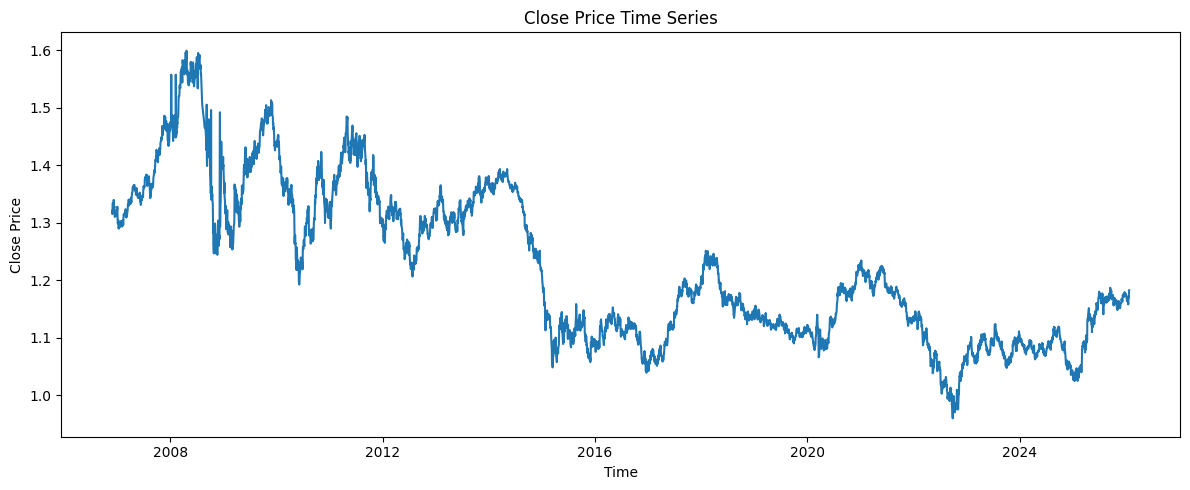

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# make sure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['close'])

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Close Price Time Series')
plt.tight_layout()
plt.show()


Based on this graph, there seems to be a slightly downward trend in the EUR:USD forex price. That could mean that the gap of EUR and USD exchange is decreasing steadily. Hence, EUR value is decreasing.
Around 2016 there seems to be a sudden drop in eur value wrt usd.

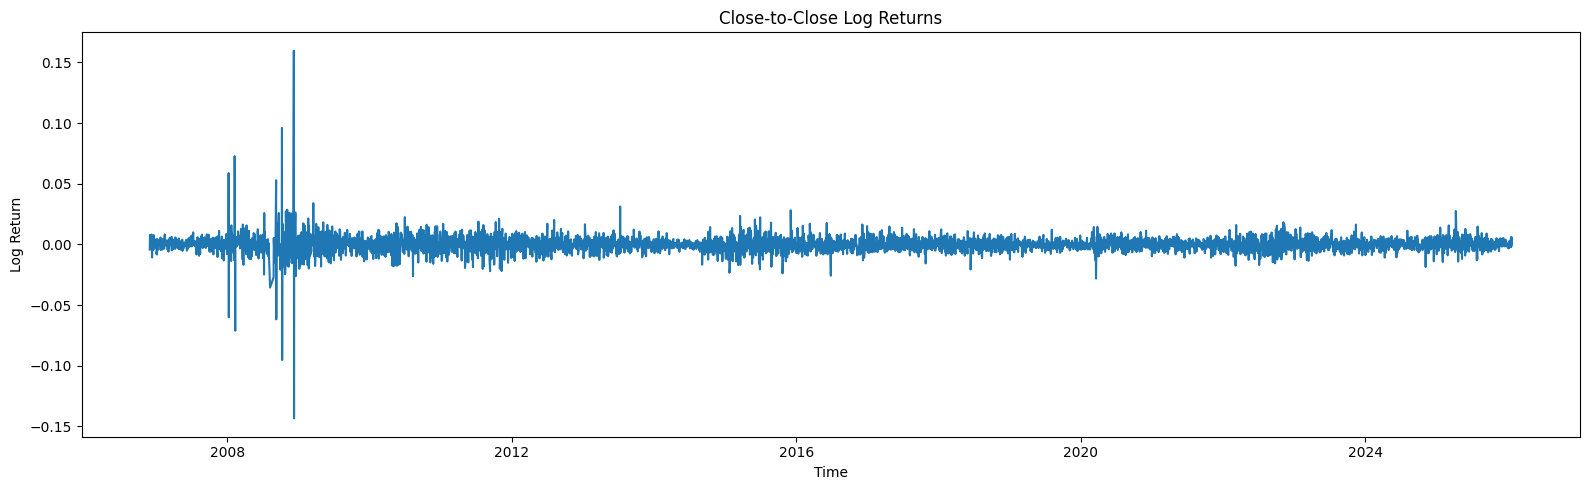

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# compute log returns
df['log_return'] = np.log(df['close']).diff()

plt.figure(figsize=(16, 5))
plt.plot(df.index, df['log_return'])


plt.xlabel('Time')
plt.ylabel('Log Return')
plt.title('Close-to-Close Log Returns')
plt.tight_layout()
plt.show()


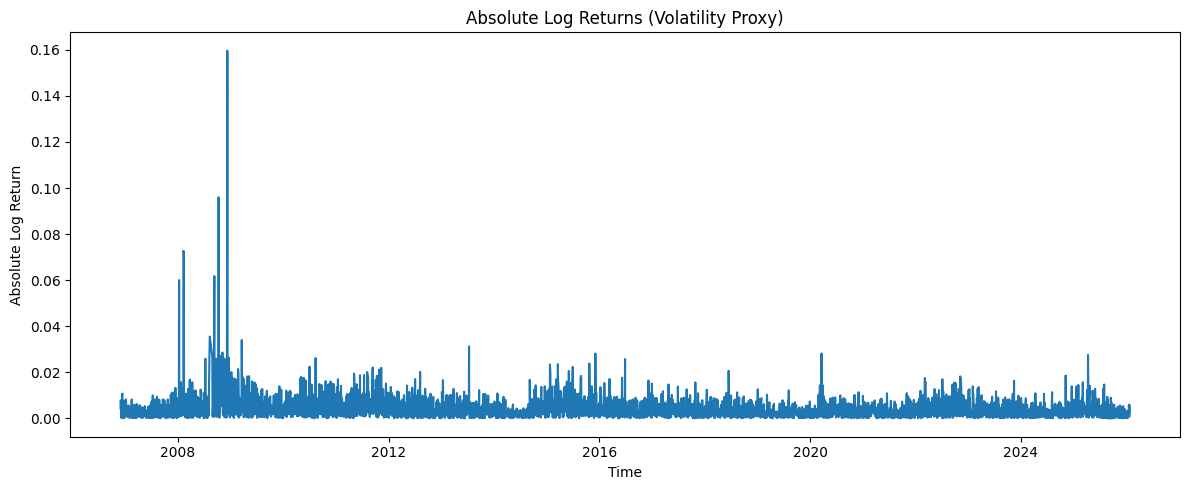

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# absolute log returns
df['abs_log_return'] = np.abs(df['log_return'])

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['abs_log_return'])

plt.xlabel('Time')
plt.ylabel('Absolute Log Return')
plt.title('Absolute Log Returns (Volatility Proxy)')
plt.tight_layout()
plt.show()


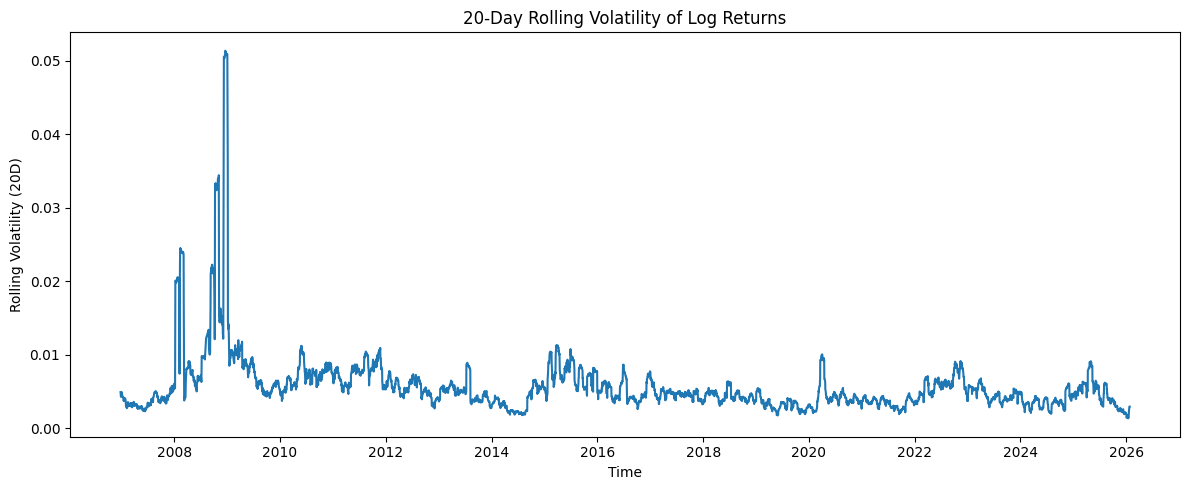

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# rolling volatility (20-day window)
df['rolling_vol_20'] = df['log_return'].rolling(window=20).std()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['rolling_vol_20'])

plt.xlabel('Time')
plt.ylabel('Rolling Volatility (20D)')
plt.title('20-Day Rolling Volatility of Log Returns')
plt.tight_layout()
plt.show()


Volatility seems to be regime-based instead of a global constant rate. Volatility is persistent within a regime, not constant over time.
Models need to take regime into account, global model assumptions are weak.

<Figure size 1800x500 with 0 Axes>

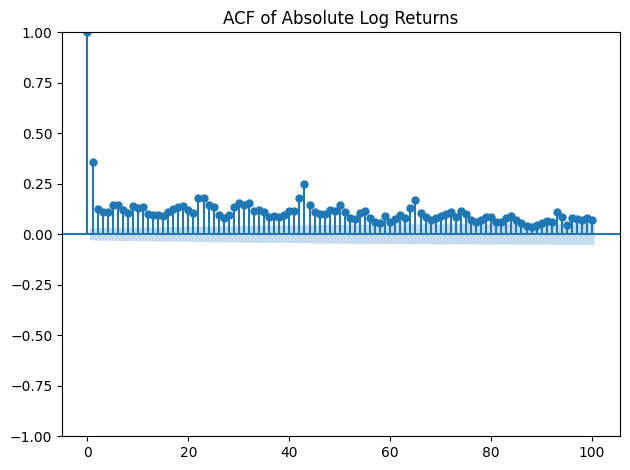

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# drop NaNs from absolute returns
abs_ret = df['abs_log_return'].dropna()

plt.figure(figsize=(18, 5))
plot_acf(abs_ret, lags=100)
plt.title('ACF of Absolute Log Returns')
plt.tight_layout()
plt.show()


The correlation of past events with future volatility lasts around 80 lags (~ 2-3 months). The effective memory for feature lookback should <= 80 trading days.
volatility forecasting is viable while directional forecasting is weak.

In [9]:
df.head()

,open,high,low,close,log_return,abs_log_return,rolling_vol_20
datetime,,,,,,,
2006-11-28,1.31340,1.32100,1.31220,1.32039,NaN,NaN,NaN
2006-11-29,1.32020,1.32141,1.31399,1.31480,-0.004243,0.004243,NaN
2006-11-30,1.31480,1.32705,1.31470,1.32510,0.007803,0.007803,NaN
2006-12-01,1.32600,1.33470,1.32235,1.33410,0.006769,0.006769,NaN
2006-12-04,1.33554,1.33554,1.32869,1.33360,-0.000375,0.000375,NaN


In [10]:
import numpy as np 

# log returns
df['log_return'] = np.log(df['close']).diff()

# absolute returns
df['abs_log_return'] = df['log_return'].abs()

# high–low range (log)
df['hl_range'] = np.log(df['high'] / df['low'])

In [11]:
windows = [5, 10, 20, 60]

for w in windows:
    df[f'vol_std_{w}'] = df['log_return'].rolling(w).std()
    df[f'vol_absmean_{w}'] = df['abs_log_return'].rolling(w).mean()
    df[f'hl_range_mean_{w}'] = df['hl_range'].rolling(w).mean()

df.head()

,open,high,low,close,log_return,abs_log_return,rolling_vol_20,hl_range,vol_std_5,vol_absmean_5,hl_range_mean_5,vol_std_10,vol_absmean_10,hl_range_mean_10,vol_std_20,vol_absmean_20,hl_range_mean_20,vol_std_60,vol_absmean_60,hl_range_mean_60
datetime,,,,,,,,,,,,,,,,,,,,
2006-11-28,1.31340,1.32100,1.31220,1.32039,NaN,NaN,NaN,0.006684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-29,1.32020,1.32141,1.31399,1.31480,-0.004243,0.004243,NaN,0.005631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-30,1.31480,1.32705,1.31470,1.32510,0.007803,0.007803,NaN,0.009350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-01,1.32600,1.33470,1.32235,1.33410,0.006769,0.006769,NaN,0.009296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-04,1.33554,1.33554,1.32869,1.33360,-0.000375,0.000375,NaN,0.005142,NaN,NaN,0.007221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df['vol_ratio_5_20'] = df['vol_std_5'] / df['vol_std_20']
df['vol_ratio_10_60'] = df['vol_std_10'] / df['vol_std_60']

df['vol_20_change_5'] = df['vol_std_20'] - df['vol_std_20'].shift(5)
df['vol_20_pct_change_5'] = df['vol_std_20'].pct_change(5)

window = 80
df['vol_20_zscore'] = (
    df['vol_std_20'] -
    df['vol_std_20'].rolling(window).mean()
) / df['vol_std_20'].rolling(window).std()

k = 2

df['large_move'] = (
    df['abs_log_return'] >
    k * df['vol_std_20']
).astype(int)

df['large_move_count_20'] = df['large_move'].rolling(20).sum()


In [13]:
df = df.dropna()

In [14]:
df

,open,high,low,close,log_return,abs_log_return,rolling_vol_20,hl_range,vol_std_5,vol_absmean_5,...,vol_std_60,vol_absmean_60,hl_range_mean_60,vol_ratio_5_20,vol_ratio_10_60,vol_20_change_5,vol_20_pct_change_5,vol_20_zscore,large_move,large_move_count_20
datetime,,,,,,,,,,,,,,,,,,,,,
2007-04-16,1.35779,1.35779,1.35291,1.35291,0.000599,0.000599,0.003281,0.003601,0.002206,0.002589,...,0.003225,0.002706,0.005103,0.672392,1.033229,0.000132,0.041826,-0.522156,0,0.0
2007-04-17,1.35311,1.35919,1.35291,1.35720,0.003166,0.003166,0.003319,0.004631,0.001461,0.002074,...,0.003177,0.002665,0.005041,0.440076,0.931194,-0.000027,-0.008146,-0.433450,0,0.0
2007-04-18,1.35720,1.36160,1.35650,1.36140,0.003090,0.003090,0.003125,0.003753,0.001239,0.002573,...,0.003114,0.002640,0.004994,0.396355,0.939019,-0.000170,-0.051466,-0.783639,0,0.0
2007-04-19,1.36160,1.36299,1.35670,1.36243,0.000756,0.000756,0.002827,0.004626,0.001235,0.001965,...,0.003095,0.002623,0.004967,0.436632,0.902397,-0.000476,-0.143980,-1.336759,0,0.0
2007-04-20,1.36251,1.36375,1.35870,1.35890,-0.002594,0.002594,0.002815,0.003710,0.002356,0.002041,...,0.003119,0.002652,0.004959,0.836996,0.912640,-0.000477,-0.144989,-1.331717,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-20,1.16432,1.17490,1.16324,1.17133,0.005977,0.005977,0.002506,0.009974,0.003891,0.003224,...,0.002267,0.001593,0.003590,1.552581,1.388711,0.001095,0.775611,0.540333,1,2.0
2026-01-21,1.17131,1.17433,1.16781,1.16913,-0.001880,0.001880,0.002523,0.005568,0.003979,0.003307,...,0.002272,0.001599,0.003616,1.577206,1.430058,0.001109,0.784919,0.597755,0,2.0
2026-01-22,1.16911,1.17503,1.16701,1.17443,0.004523,0.004523,0.002732,0.006849,0.004128,0.004060,...,0.002342,0.001671,0.003718,1.510878,1.455124,0.001276,0.876985,1.090660,0,2.0


In [15]:
df.columns

Index(['open', 'high', 'low', 'close', 'log_return', 'abs_log_return',
       'rolling_vol_20', 'hl_range', 'vol_std_5', 'vol_absmean_5',
       'hl_range_mean_5', 'vol_std_10', 'vol_absmean_10', 'hl_range_mean_10',
       'vol_std_20', 'vol_absmean_20', 'hl_range_mean_20', 'vol_std_60',
       'vol_absmean_60', 'hl_range_mean_60', 'vol_ratio_5_20',
       'vol_ratio_10_60', 'vol_20_change_5', 'vol_20_pct_change_5',
       'vol_20_zscore', 'large_move', 'large_move_count_20'],
      dtype='object')

In [19]:
df["tomorrow"] = df["close"].shift(-1)
df = df.dropna()
df["target"] = (df["close"] < df["tomorrow"]).astype(int)
df

/var/folders/5l/17wd4myj387b056cpgkkpxth0000gn/T/ipykernel_59867/4257315511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = (df["close"] < df["tomorrow"]).astype(int)


,open,high,low,close,log_return,abs_log_return,rolling_vol_20,hl_range,vol_std_5,vol_absmean_5,...,hl_range_mean_60,vol_ratio_5_20,vol_ratio_10_60,vol_20_change_5,vol_20_pct_change_5,vol_20_zscore,large_move,large_move_count_20,tomorrow,target
datetime,,,,,,,,,,,,,,,,,,,,,
2007-04-16,1.35779,1.35779,1.35291,1.35291,0.000599,0.000599,0.003281,0.003601,0.002206,0.002589,...,0.005103,0.672392,1.033229,0.000132,0.041826,-0.522156,0,0.0,1.35720,1
2007-04-17,1.35311,1.35919,1.35291,1.35720,0.003166,0.003166,0.003319,0.004631,0.001461,0.002074,...,0.005041,0.440076,0.931194,-0.000027,-0.008146,-0.433450,0,0.0,1.36140,1
2007-04-18,1.35720,1.36160,1.35650,1.36140,0.003090,0.003090,0.003125,0.003753,0.001239,0.002573,...,0.004994,0.396355,0.939019,-0.000170,-0.051466,-0.783639,0,0.0,1.36243,1
2007-04-19,1.36160,1.36299,1.35670,1.36243,0.000756,0.000756,0.002827,0.004626,0.001235,0.001965,...,0.004967,0.436632,0.902397,-0.000476,-0.143980,-1.336759,0,0.0,1.35890,0
2007-04-20,1.36251,1.36375,1.35870,1.35890,-0.002594,0.002594,0.002815,0.003710,0.002356,0.002041,...,0.004959,0.836996,0.912640,-0.000477,-0.144989,-1.331717,0,0.0,1.35840,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-19,1.15783,1.16494,1.15754,1.16435,0.005590,0.005590,0.002073,0.006373,0.003296,0.002434,...,0.003533,1.589976,1.152930,0.000695,0.503949,-0.440709,1,1.0,1.17133,1
2026-01-20,1.16432,1.17490,1.16324,1.17133,0.005977,0.005977,0.002506,0.009974,0.003891,0.003224,...,0.003590,1.552581,1.388711,0.001095,0.775611,0.540333,1,2.0,1.16913,0
2026-01-21,1.17131,1.17433,1.16781,1.16913,-0.001880,0.001880,0.002523,0.005568,0.003979,0.003307,...,0.003616,1.577206,1.430058,0.001109,0.784919,0.597755,0,2.0,1.17443,1


In [27]:
test_df = df.iloc[-250:]
train_df = df.iloc[:-250]
print(test_df.shape)
print(train_df.shape)

(250, 29)
(4650, 29)


In [28]:
train_df.columns

Index(['open', 'high', 'low', 'close', 'log_return', 'abs_log_return',
       'rolling_vol_20', 'hl_range', 'vol_std_5', 'vol_absmean_5',
       'hl_range_mean_5', 'vol_std_10', 'vol_absmean_10', 'hl_range_mean_10',
       'vol_std_20', 'vol_absmean_20', 'hl_range_mean_20', 'vol_std_60',
       'vol_absmean_60', 'hl_range_mean_60', 'vol_ratio_5_20',
       'vol_ratio_10_60', 'vol_20_change_5', 'vol_20_pct_change_5',
       'vol_20_zscore', 'large_move', 'large_move_count_20', 'tomorrow',
       'target'],
      dtype='object')

In [29]:
# 1. Identify columns with wildcard patterns
vol_cols = [c for c in train_df.columns if 'vol_absmean_' in c]
hl_mean_cols = [c for c in train_df.columns if 'hl_range_mean_' in c]

# 2. Combine all columns to drop
cols_to_drop = [
    "open", "high", "low", "close", 
    "tomorrow", "target", 
    "log_return", "abs_log_return", 
    "hl_range", "large_move"
] + vol_cols + hl_mean_cols

# 3. Create the predictors list
# Using errors='ignore' ensures the code doesn't crash if a column was already removed
predictors = train_df.columns.drop(cols_to_drop, errors='ignore')

In [30]:
predictors

Index(['rolling_vol_20', 'vol_std_5', 'vol_std_10', 'vol_std_20', 'vol_std_60',
       'vol_ratio_5_20', 'vol_ratio_10_60', 'vol_20_change_5',
       'vol_20_pct_change_5', 'vol_20_zscore', 'large_move_count_20'],
      dtype='object')

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score

model = RandomForestClassifier(
    n_estimators=165,
    max_depth=14,
    min_samples_split=4
)

tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=250,
    gap=1
)

X = train_df[predictors]
y = train_df["target"]

precision_scores = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(
        X=X_tr,
        y=y_tr
    )

    preds = model.predict(X_val)
    fold_score = precision_score(y_val, preds)
    precision_scores.append(fold_score)

    print(f"Fold {i+1} Precision Score: {fold_score:.4f}") 

print(f"\n✅ Avg CV Precision Score: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")



Fold 1 Precision Score: 0.5342
Fold 2 Precision Score: 0.4750
Fold 3 Precision Score: 0.4565
Fold 4 Precision Score: 0.4701
Fold 5 Precision Score: 0.5044

✅ Avg CV Precision Score: 0.4881 ± 0.0279


In [34]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score

model = RandomForestClassifier(
    n_estimators=165,
    max_depth=14,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=250,
    gap=1
)

X = train_df[predictors]
y = train_df["target"]

pr_auc_scores = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_tr, y_tr)

    # probabilities, not hard labels
    probs = model.predict_proba(X_val)[:, 1]

    pr_auc = average_precision_score(y_val, probs)
    pr_auc_scores.append(pr_auc)

    print(f"Fold {i+1} PR-AUC: {pr_auc:.4f}")

print(
    f"\n✅ Avg CV PR-AUC: {np.mean(pr_auc_scores):.4f} "
    f"± {np.std(pr_auc_scores):.4f}"
)


Fold 1 PR-AUC: 0.5655
Fold 2 PR-AUC: 0.4866
Fold 3 PR-AUC: 0.4759
Fold 4 PR-AUC: 0.4586
Fold 5 PR-AUC: 0.5245

✅ Avg CV PR-AUC: 0.5022 ± 0.0383


In [35]:
from sklearn.metrics import average_precision_score

# probabilities, not hard predictions
test_probs = model.predict_proba(test_df[predictors])[:, 1]

# PR-AUC
test_pr_auc = average_precision_score(
    test_df["target"],
    test_probs
)

print(f"✅ Test PR-AUC: {test_pr_auc:.4f}")


✅ Test PR-AUC: 0.5036
